<p id="part0"></p>
<h1>ARIMA VS XGBOOST VS GRU</h1>

<p>@syahrulmwijaya</p>

<p>those are three popular method to do forecasting right now. ARIMA is kind of traditional method to forecast a variable. or in the sense that ARIMA is a statistical method to analyze time-series data by combining three component to model time-series data which are Auto-Regressive, Integral, and Moving Average. XGBOOST in the other side is a powerful and efficient open-source machine learning library that is use for classification, regression, and ranking problems. and last but not least is GRU or Gated Recurrent Unit is a type of recurrent neural network (RNN) architecture that is commonly used for natural language processing (NLP) and other sequential data tasks.</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

import xgboost as xgb

from scipy.stats import boxcox


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("/kaggle/input/data-transaksixlsx/Data Transaksi Fix.xlsx", parse_dates=['Tanggal Invoice'], index_col='Tanggal Invoice')
df.head()

,No. Invoice,Negara,Kode Stok,Deskripsi,Kuantitas,Harga per Unit
Tanggal Invoice,,,,,,
2010-12-01 08:26:00,536365,Britania Raya,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55
2010-12-01 08:26:00,536365,Britania Raya,71053,WHITE METAL LANTERN,6,3.39
2010-12-01 08:26:00,536365,Britania Raya,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75
2010-12-01 08:26:00,536365,Britania Raya,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39
2010-12-01 08:26:00,536365,Britania Raya,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39


In [3]:
df['sales'] = df['Kuantitas']*df['Harga per Unit']
df.head()

,No. Invoice,Negara,Kode Stok,Deskripsi,Kuantitas,Harga per Unit,sales
Tanggal Invoice,,,,,,,
2010-12-01 08:26:00,536365,Britania Raya,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30
2010-12-01 08:26:00,536365,Britania Raya,71053,WHITE METAL LANTERN,6,3.39,20.34
2010-12-01 08:26:00,536365,Britania Raya,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00
2010-12-01 08:26:00,536365,Britania Raya,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34
2010-12-01 08:26:00,536365,Britania Raya,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34


In [4]:
df_total = df[['sales']]
df_total

,sales
Tanggal Invoice,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34
...,...
2011-12-09 12:50:00,10.20
2011-12-09 12:50:00,12.60
2011-12-09 12:50:00,16.60


In [5]:
df_total = df_total.groupby(df_total.index).sum()
df_total

,sales
Tanggal Invoice,
2010-12-01 08:26:00,139.12
2010-12-01 08:28:00,22.20
2010-12-01 08:34:00,348.78
2010-12-01 08:35:00,17.85
2010-12-01 08:45:00,855.86
...,...
2011-12-09 12:23:00,124.60
2011-12-09 12:25:00,140.64
2011-12-09 12:31:00,329.05


In [6]:
hourly_df = df_total.resample('H').sum()
hourly_df

,sales
Tanggal Invoice,
2010-12-01 08:00:00,1383.81
2010-12-01 09:00:00,7356.39
2010-12-01 10:00:00,5235.81
2010-12-01 11:00:00,4234.16
2010-12-01 12:00:00,7447.92
...,...
2011-12-09 08:00:00,3581.93
2011-12-09 09:00:00,171679.08
2011-12-09 10:00:00,19663.42


In [7]:
daily_df = df_total.resample('D').sum()
daily_df

,sales
Tanggal Invoice,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95
...,...
2011-12-05,88741.96
2011-12-06,56713.21
2011-12-07,75439.16


In [8]:
weekly_df = daily_df.resample('W').sum()
weekly_df

,sales
Tanggal Invoice,
2010-12-05,185427.830
2010-12-12,329936.810
2010-12-19,216012.200
2010-12-26,92369.300
2011-01-02,0.000
2011-01-09,133658.190
2011-01-16,193362.040
2011-01-23,215533.180
2011-01-30,125170.790


In [9]:
monthly_df = daily_df.resample("M").sum()
monthly_df

,sales
Tanggal Invoice,
2010-12-31,823746.140
2011-01-31,691364.560
2011-02-28,523631.890
2011-03-31,717639.360
2011-04-30,537808.621
2011-05-31,770536.020
2011-06-30,761739.900
2011-07-31,719221.191
2011-08-31,748076.320


<p id="part1"></p>
<h2>ARIMA Model</h2>

<AxesSubplot:xlabel='Tanggal Invoice'>

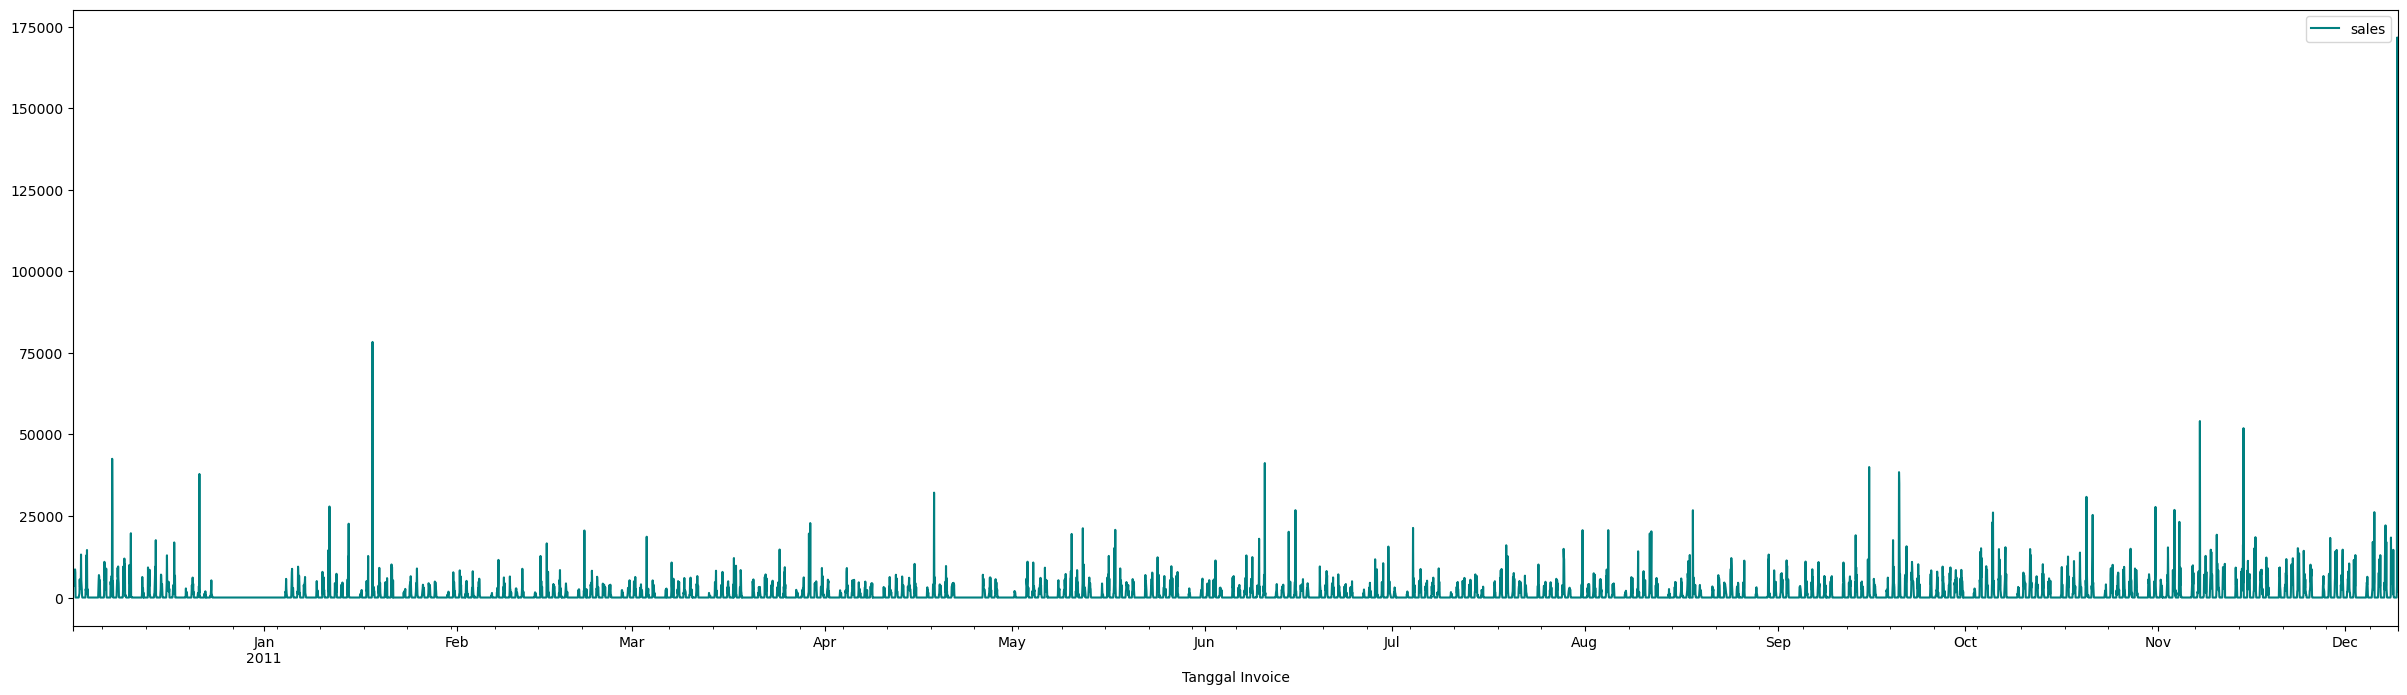

In [10]:
fig,ax = plt.subplots(figsize=(30,8))
hourly_df.plot(color='teal', ax=ax)

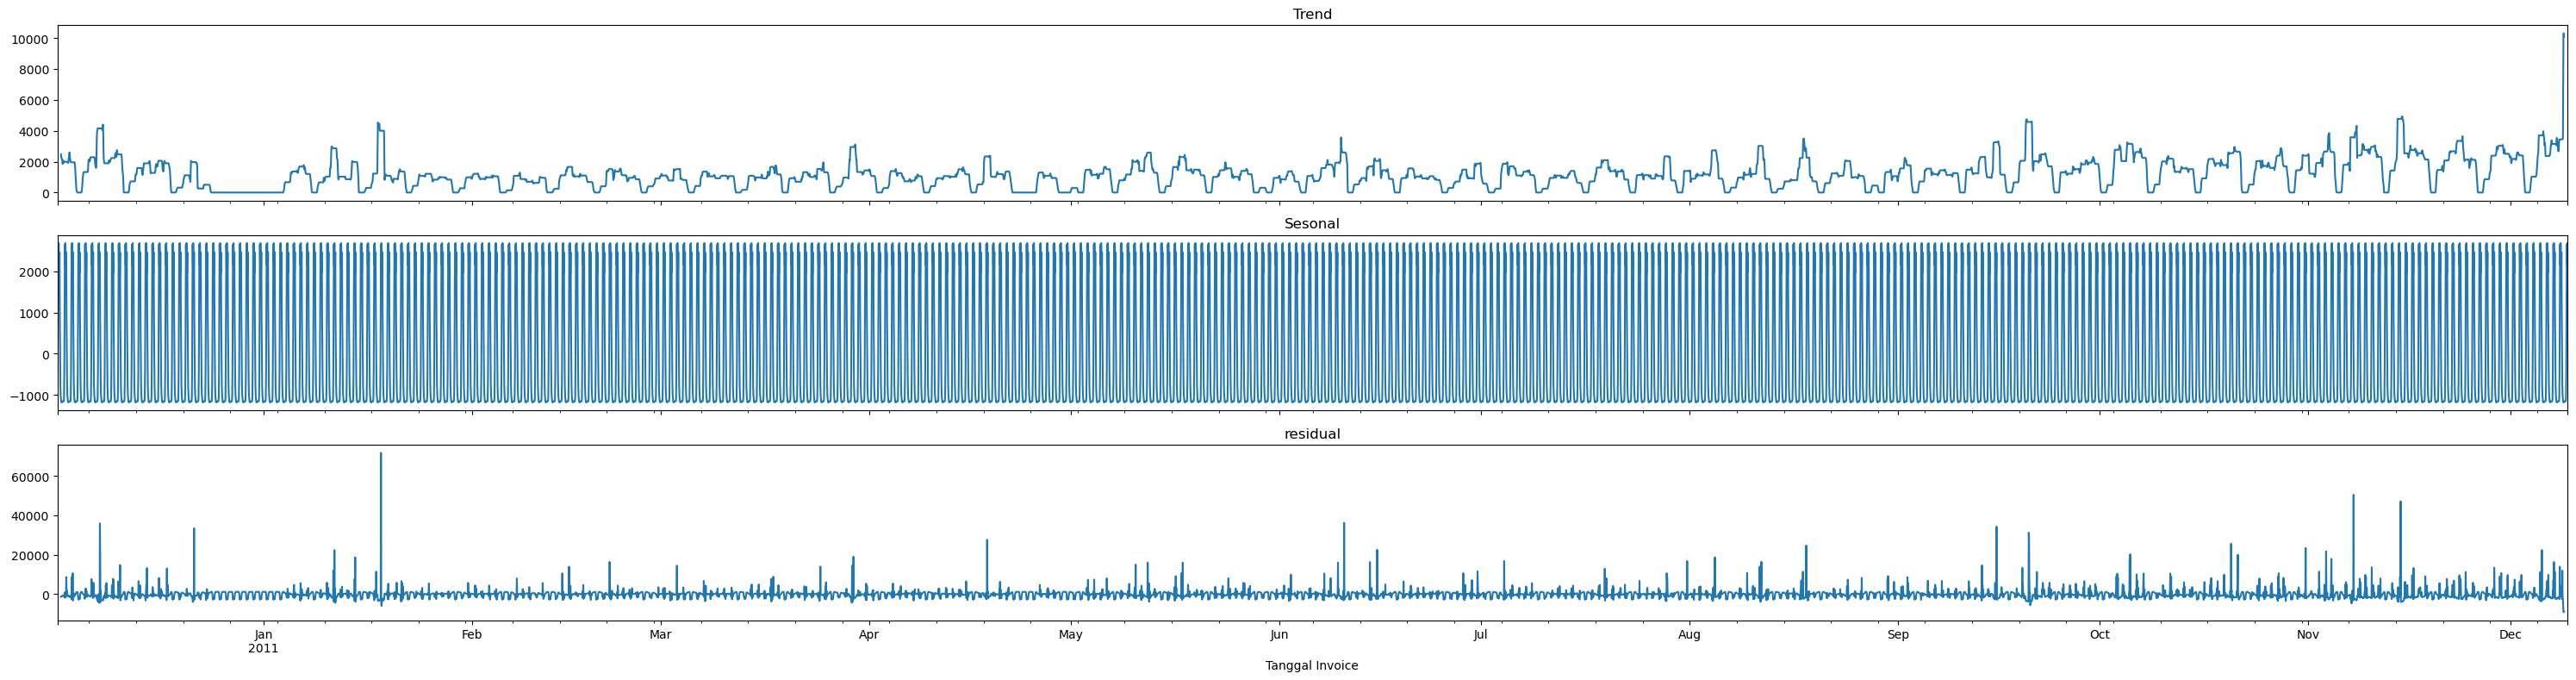

In [11]:
decomposed = seasonal_decompose(hourly_df, model='additive')
fig, ax = plt.subplots(3, 1, figsize=(30,8))
decomposed.trend.plot(ax=ax[0])
ax[0].set_title('Trend')
decomposed.seasonal.plot(ax=ax[1])
ax[1].set_title('Sesonal')
decomposed.resid.plot(ax=ax[2])
ax[2].set_title('residual')

for i in range(0, 2):
    ax[i].set_xticklabels([]) 
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()


In [12]:
rolmean = hourly_df.rolling(window=12).mean()
rolstd = hourly_df.rolling(window=12).std()
rolmean, rolstd

(                            sales
 Tanggal Invoice                  
 2010-12-01 08:00:00           NaN
 2010-12-01 09:00:00           NaN
 2010-12-01 10:00:00           NaN
 2010-12-01 11:00:00           NaN
 2010-12-01 12:00:00           NaN
 ...                           ...
 2011-12-09 08:00:00    298.494167
 2011-12-09 09:00:00  14605.084167
 2011-12-09 10:00:00  16243.702500
 2011-12-09 11:00:00  16399.010000
 2011-12-09 12:00:00  16743.383333
 
 [8957 rows x 1 columns],
                             sales
 Tanggal Invoice                  
 2010-12-01 08:00:00           NaN
 2010-12-01 09:00:00           NaN
 2010-12-01 10:00:00           NaN
 2010-12-01 11:00:00           NaN
 2010-12-01 12:00:00           NaN
 ...                           ...
 2011-12-09 08:00:00   1034.014125
 2011-12-09 09:00:00  49476.197151
 2011-12-09 10:00:00  49273.718209
 2011-12-09 11:00:00  49220.773341
 2011-12-09 12:00:00  49109.938750
 
 [8957 rows x 1 columns])

<AxesSubplot:xlabel='Tanggal Invoice'>

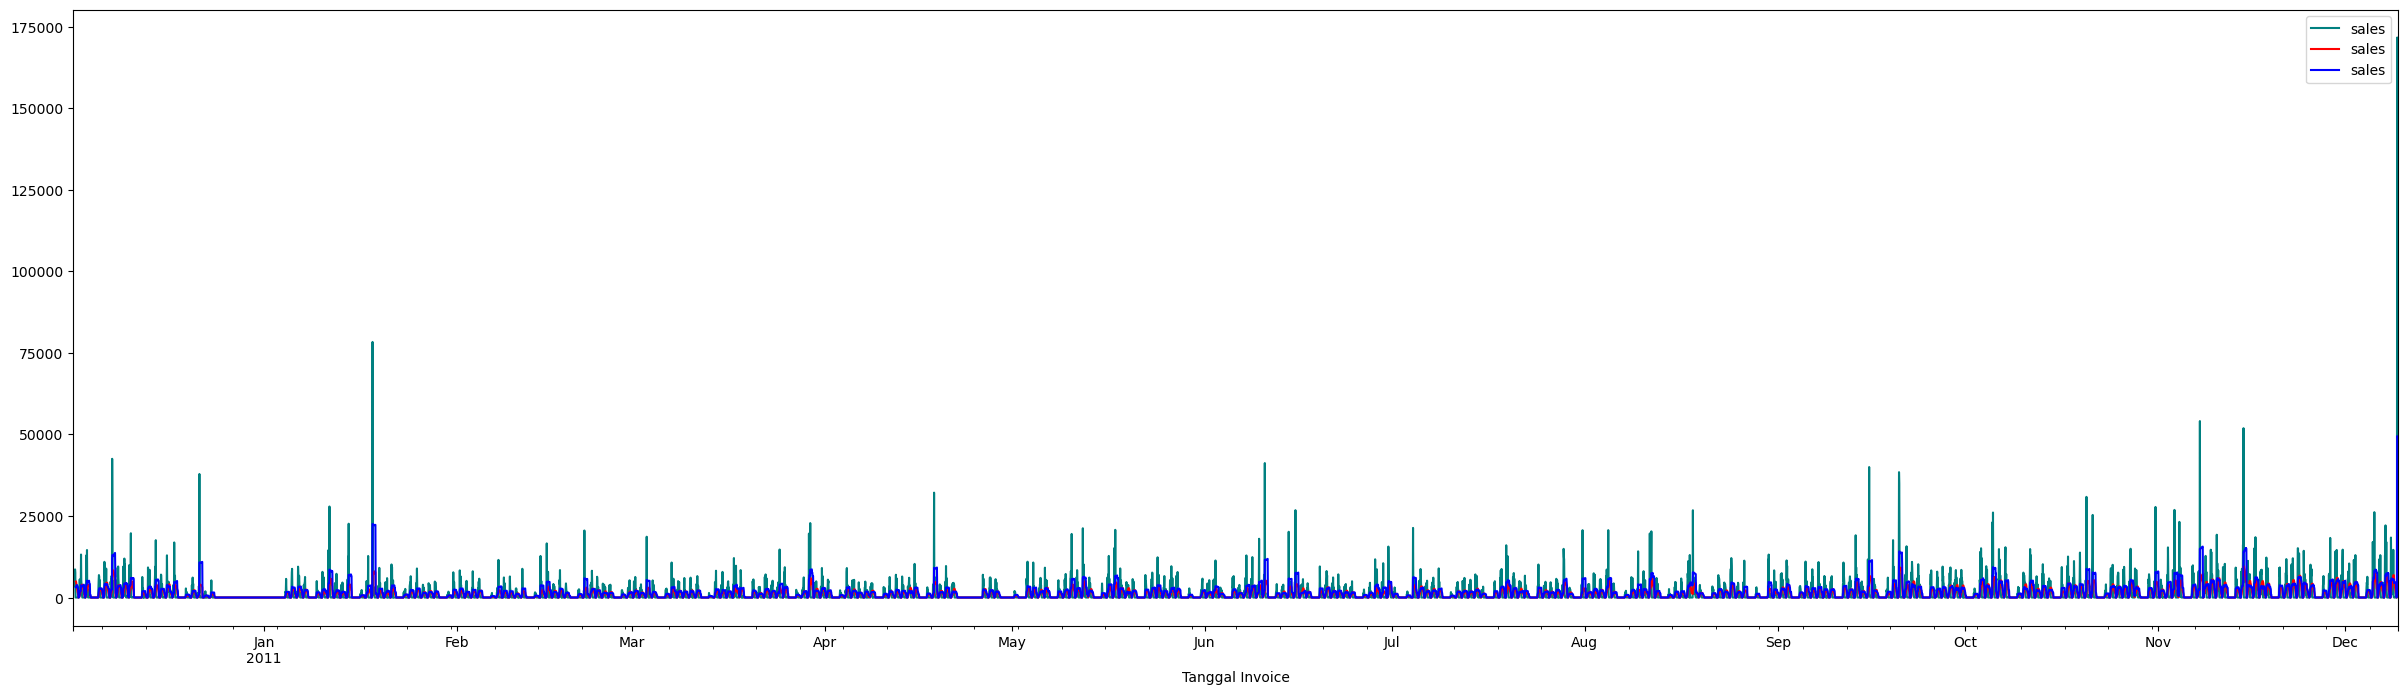

In [13]:
fig, ax = plt.subplots(figsize=(30,8))
hourly_df.plot(color='teal',ax=ax)
rolmean.plot(color='red', ax=ax)
rolstd.plot(color='blue', ax=ax)

In [14]:
def ADFtest(df):
    dftest = adfuller(df, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    fig, ax = plt.subplots(figsize=(30,8))
    
    #l1 =df.plot(color='teal',ax=ax, label='original')
    l1, = ax.plot(df, color='teal')
    l1.set_label("original")
    l2, = ax.plot(rolmean, color='red')
    l2.set_label("rolling mean")
    l3, = ax.plot(rolstd, color='blue')
    l3.set_label("rolling std")
    '''
    line = l1.get_lines()
    line.set_label('new label')
    
    line = l2.get_lines()
    line.set_label('new label')
    
    line = l3.get_lines()
    line.set_label('new label')
    '''
    ax.legend()
    plt.show()
    print(dfoutput)    

In [15]:
def acfpacf(df):
    fig, ax = plt.subplots(1, 2, figsize=(30,8))
    plot_acf(df, ax=ax[0]);
    plot_pacf(df, ax=ax[1]);

In [16]:
per80 = int(len(hourly_df)*0.8)
'''
train = df_daily[:per80]
test = df_daily[per80:]
'''
train = hourly_df[:per80]
test = hourly_df[per80:]
train

,sales
Tanggal Invoice,
2010-12-01 08:00:00,1383.81
2010-12-01 09:00:00,7356.39
2010-12-01 10:00:00,5235.81
2010-12-01 11:00:00,4234.16
2010-12-01 12:00:00,7447.92
...,...
2011-09-25 16:00:00,601.54
2011-09-25 17:00:00,0.00
2011-09-25 18:00:00,0.00


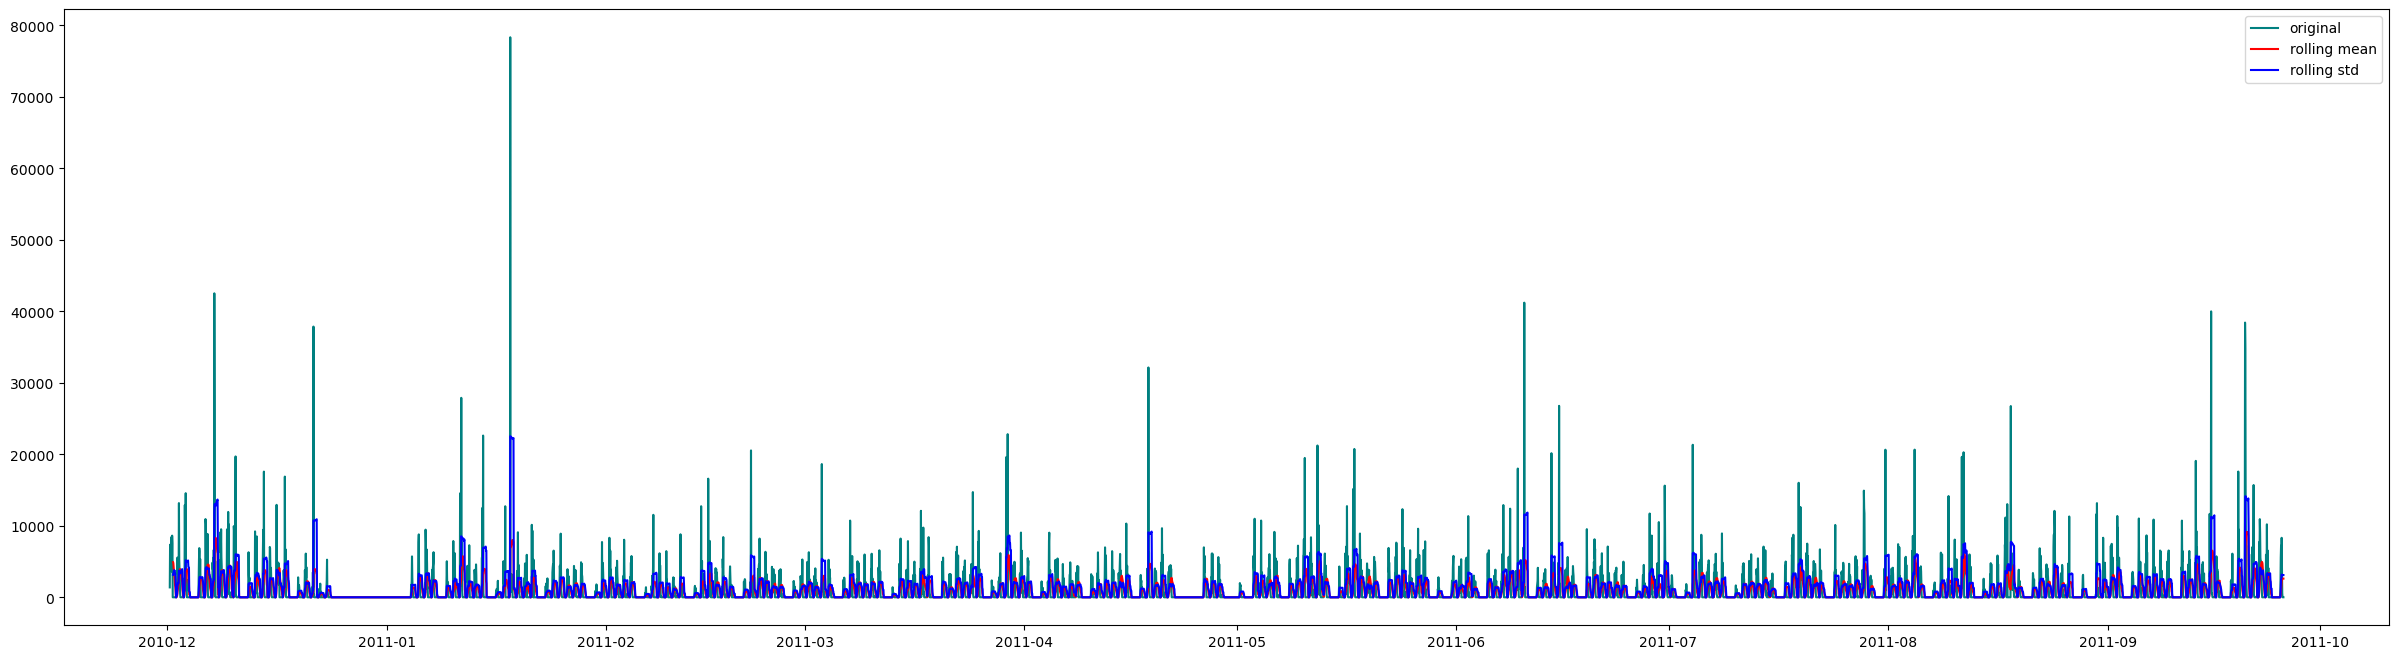

Test Statistic                -1.127021e+01
p-value                        1.543514e-20
#Lags Used                     3.100000e+01
Number of Observations Used    7.133000e+03
Critical Value (1%)           -3.431267e+00
Critical Value (5%)           -2.861945e+00
Critical Value (10%)          -2.566986e+00
dtype: float64


In [17]:
ADFtest(train)

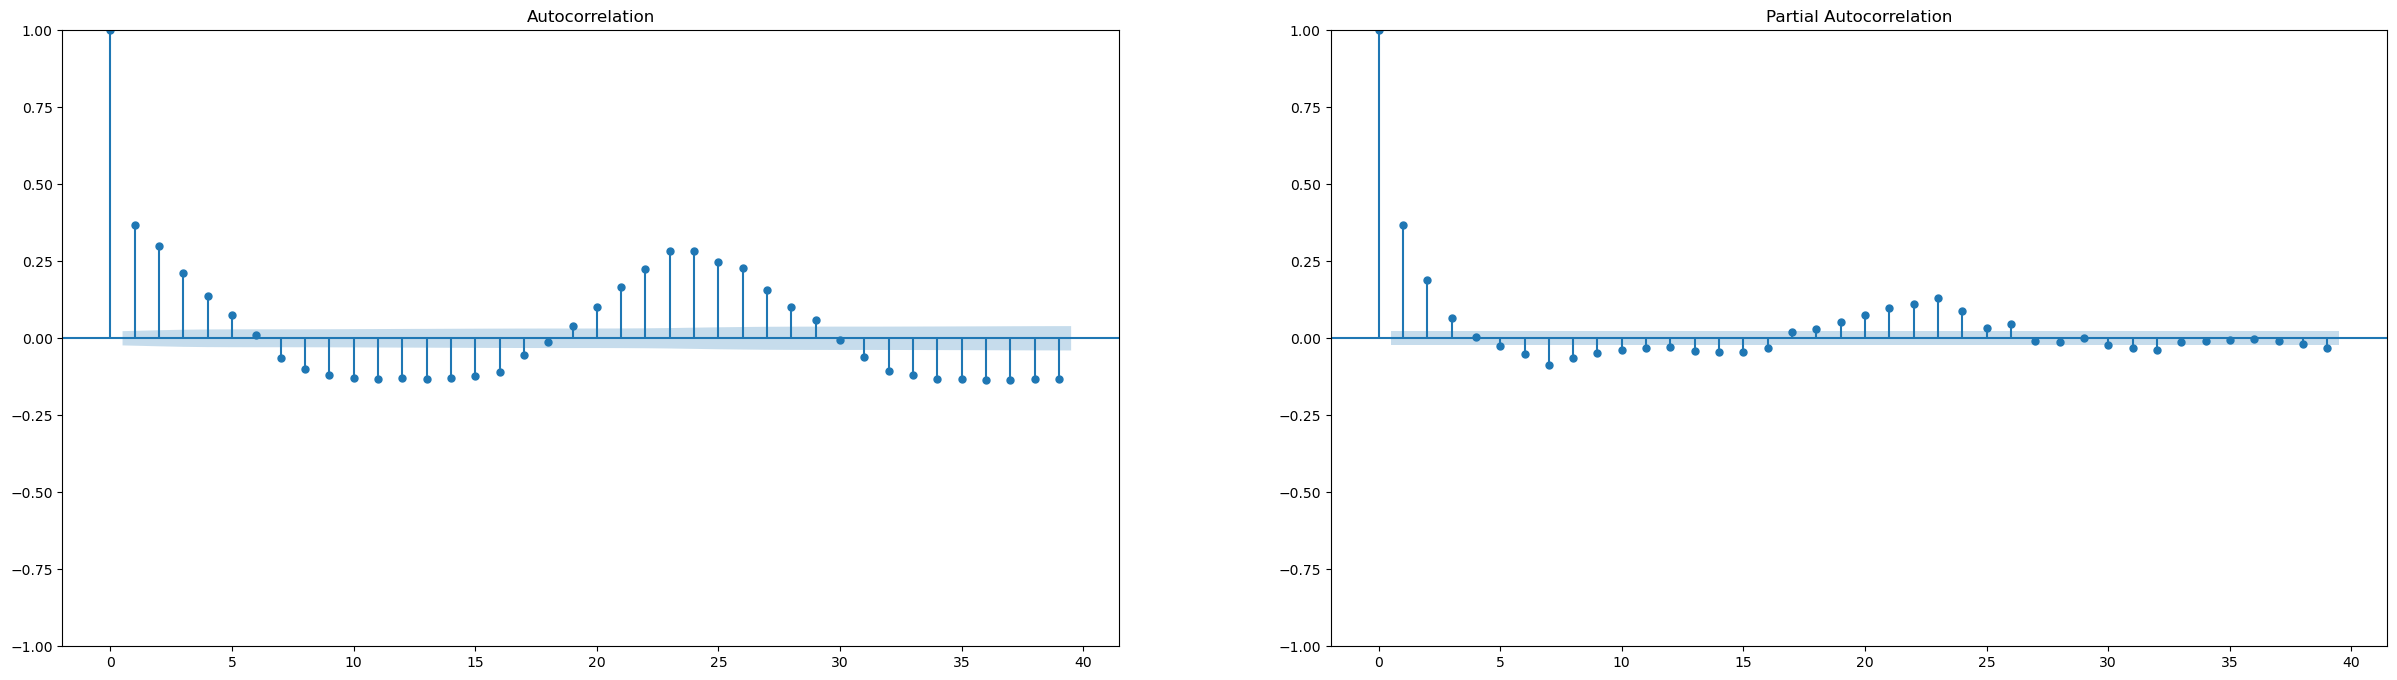

In [18]:
acfpacf(train)

In [19]:
diff_train = train.diff()
diff_train = diff_train[1:]
diff_train

,sales
Tanggal Invoice,
2010-12-01 09:00:00,5972.58
2010-12-01 10:00:00,-2120.58
2010-12-01 11:00:00,-1001.65
2010-12-01 12:00:00,3213.76
2010-12-01 13:00:00,-2384.38
...,...
2011-09-25 16:00:00,-3713.03
2011-09-25 17:00:00,-601.54
2011-09-25 18:00:00,0.00


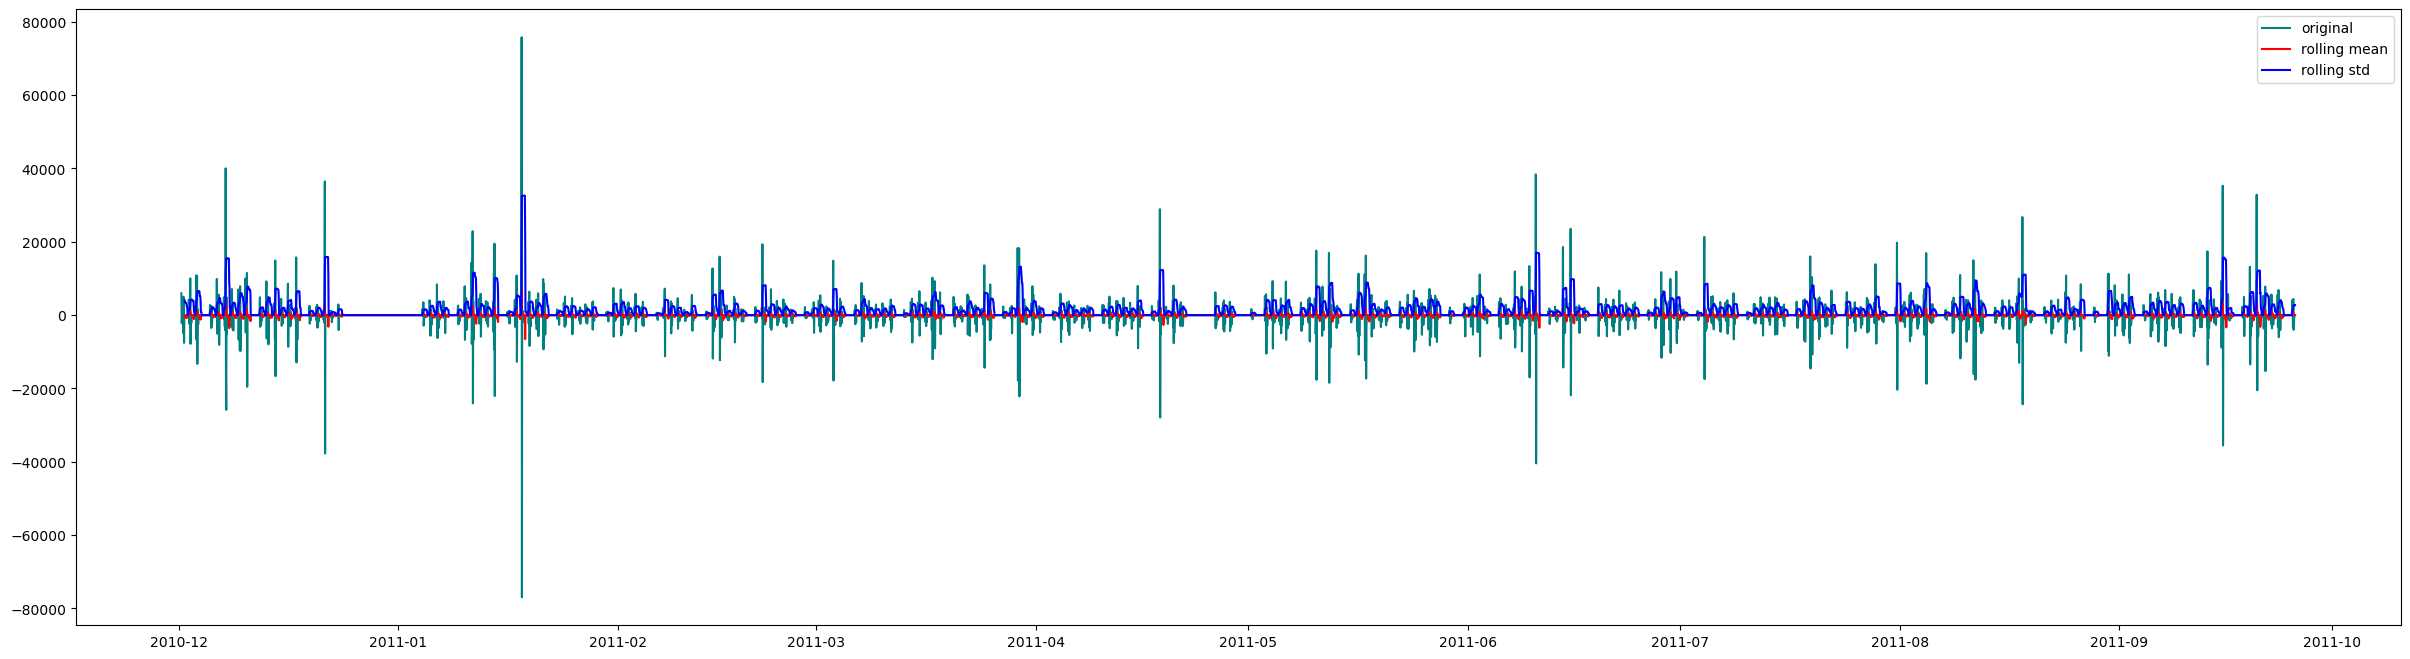

Test Statistic                  -39.485956
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    7139.000000
Critical Value (1%)              -3.431266
Critical Value (5%)              -2.861945
Critical Value (10%)             -2.566986
dtype: float64


In [20]:
ADFtest(diff_train)

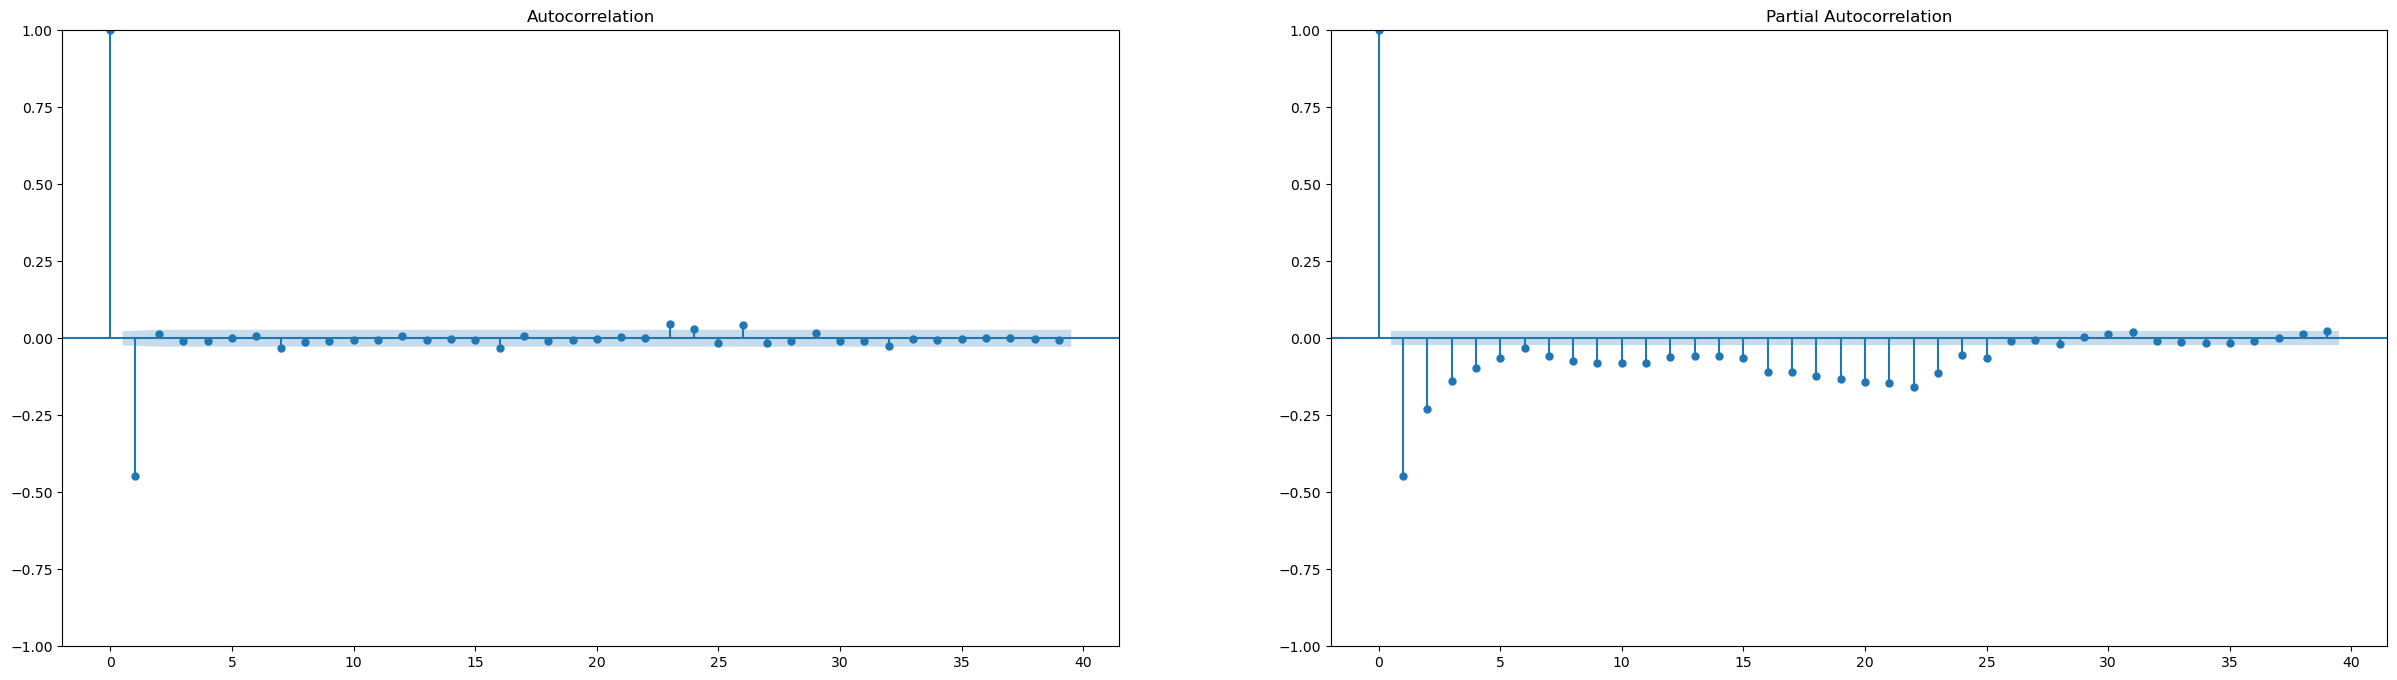

In [21]:
acfpacf(diff_train)

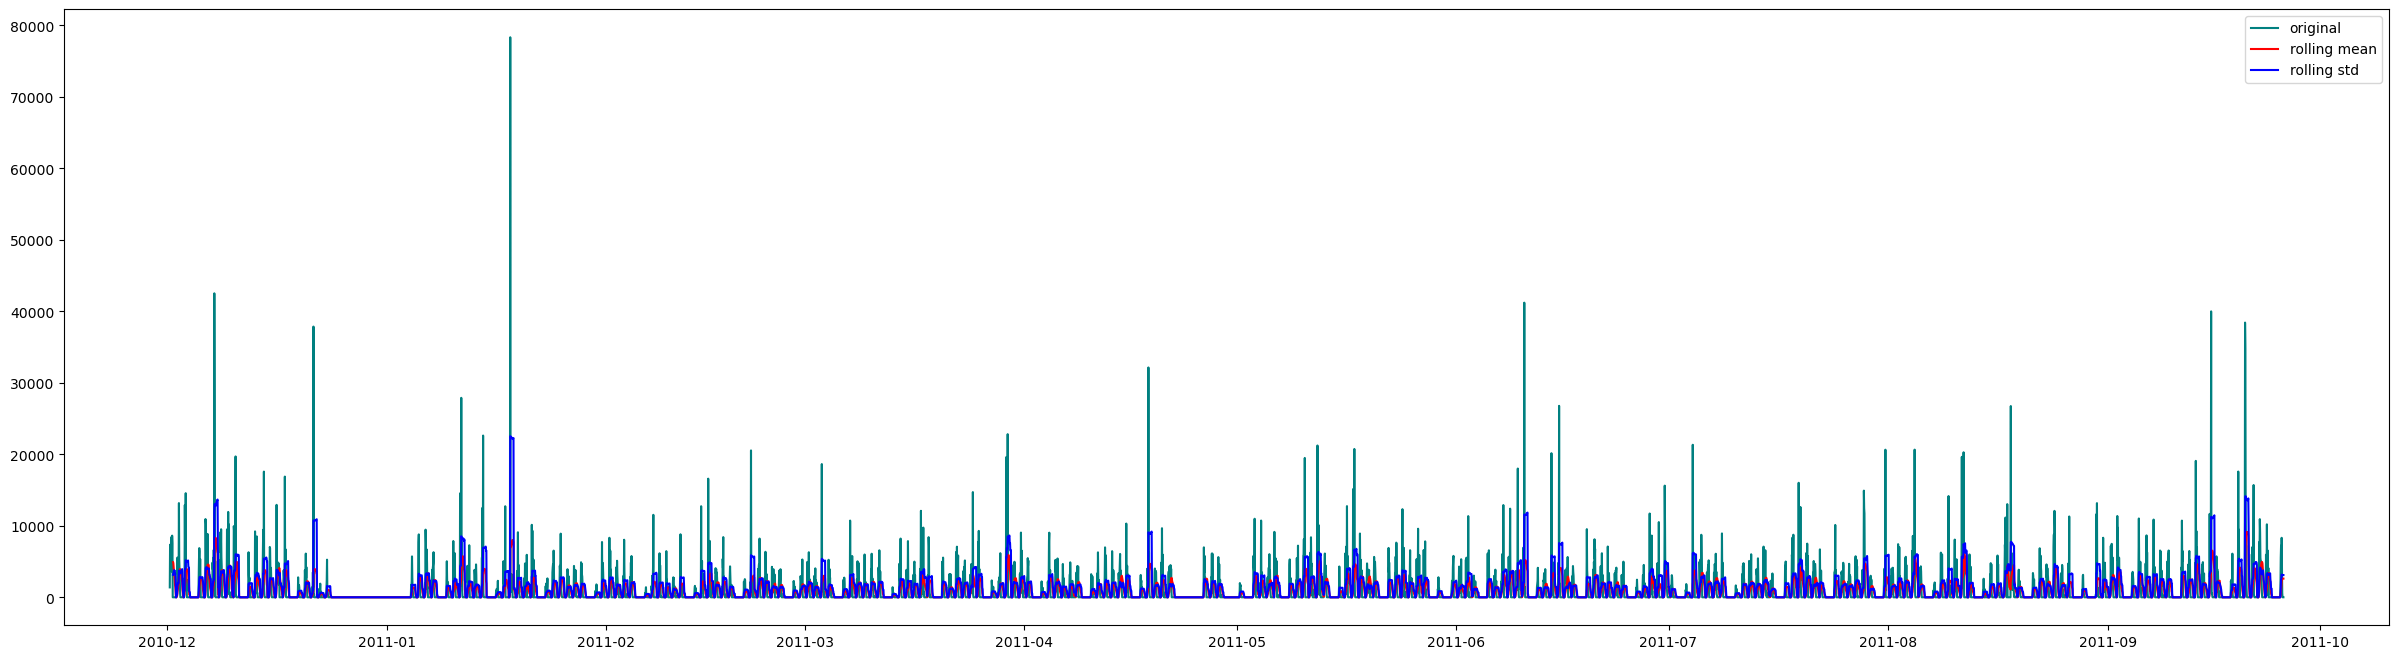

Test Statistic                -1.127021e+01
p-value                        1.543514e-20
#Lags Used                     3.100000e+01
Number of Observations Used    7.133000e+03
Critical Value (1%)           -3.431267e+00
Critical Value (5%)           -2.861945e+00
Critical Value (10%)          -2.566986e+00
dtype: float64


In [22]:
ADFtest(train)

<AxesSubplot:xlabel='Tanggal Invoice'>

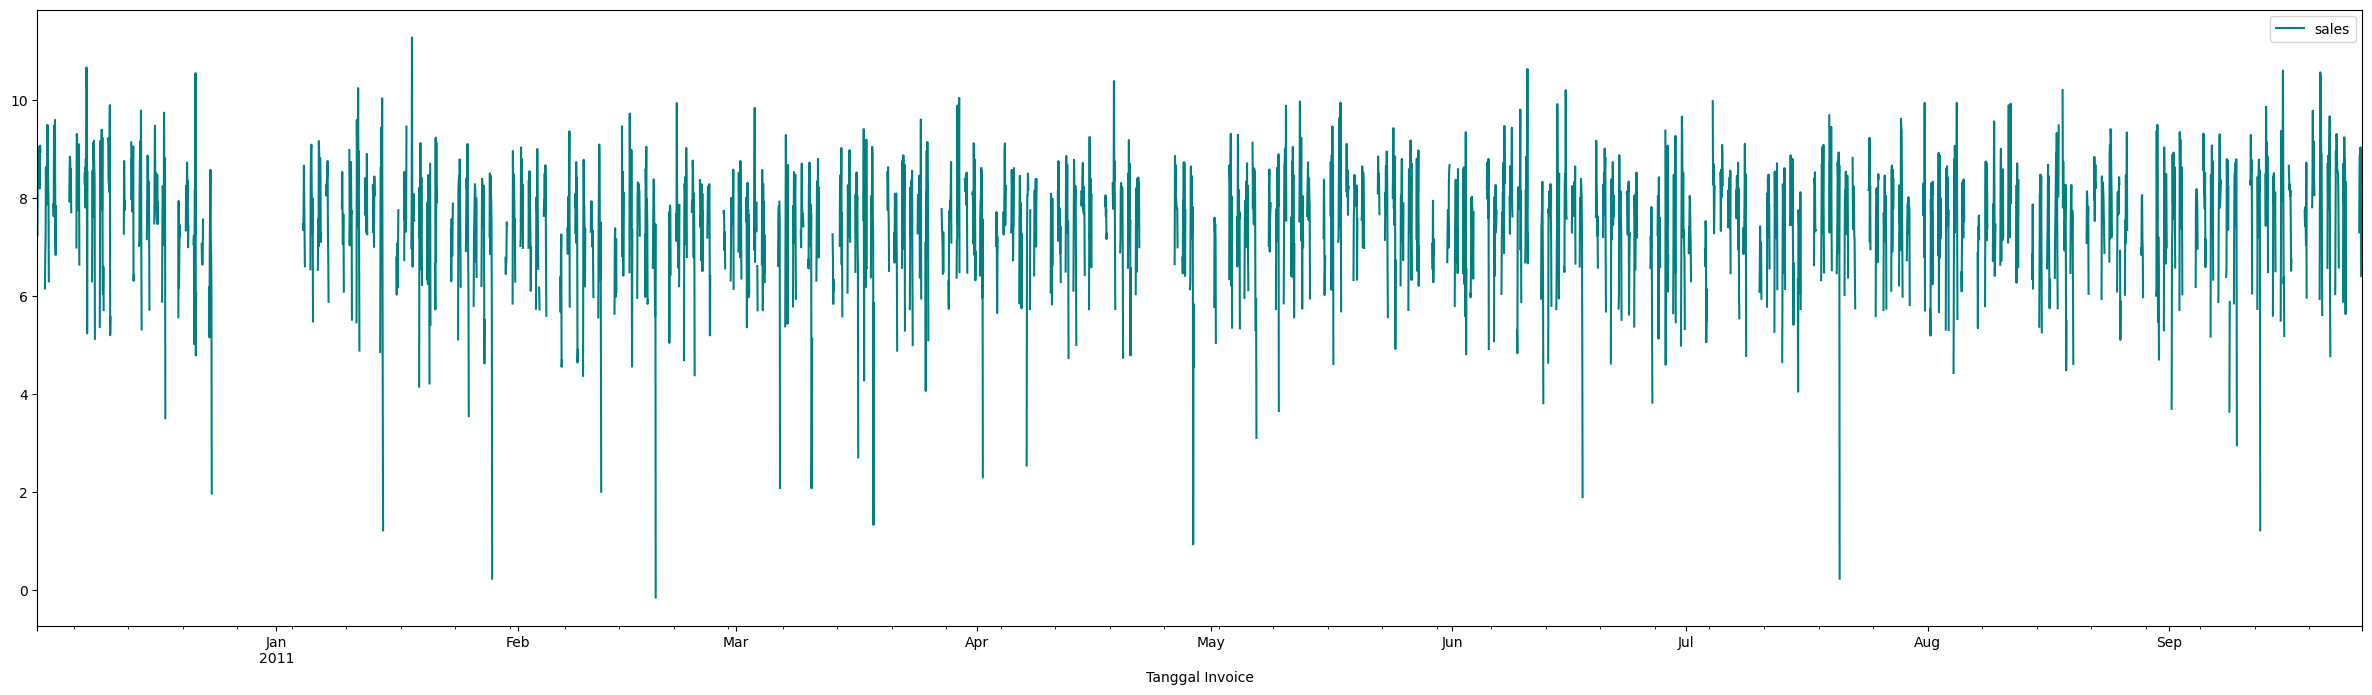

In [23]:
train_log = train.copy()
train_log = np.log(train_log)
fig,ax=plt.subplots(figsize=(30,8))
train_log.plot(color='teal', ax=ax)

In [24]:
#used to determine the order automatically
'''
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')
'''

"\nresDiff = sm.tsa.arma_order_select_ic(train, max_ar=7, max_ma=7, ic='aic', trend='c')\nprint('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')\n"

In [25]:
model = sm.tsa.ARIMA(train, order=(25,1,7))
results_model = model.fit()
print(results_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 7165
Model:                ARIMA(25, 1, 7)   Log Likelihood              -65844.810
Date:                Tue, 14 Mar 2023   AIC                         131755.620
Time:                        06:10:40   BIC                         131982.556
Sample:                    12-01-2010   HQIC                        131833.728
                         - 09-25-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5209      0.404     -1.290      0.197      -1.312       0.271
ar.L2          0.1513      0.316      0.479      0.632      -0.467       0.770
ar.L3          0.4904      0.310      1.583      0.1

Plotting AR model


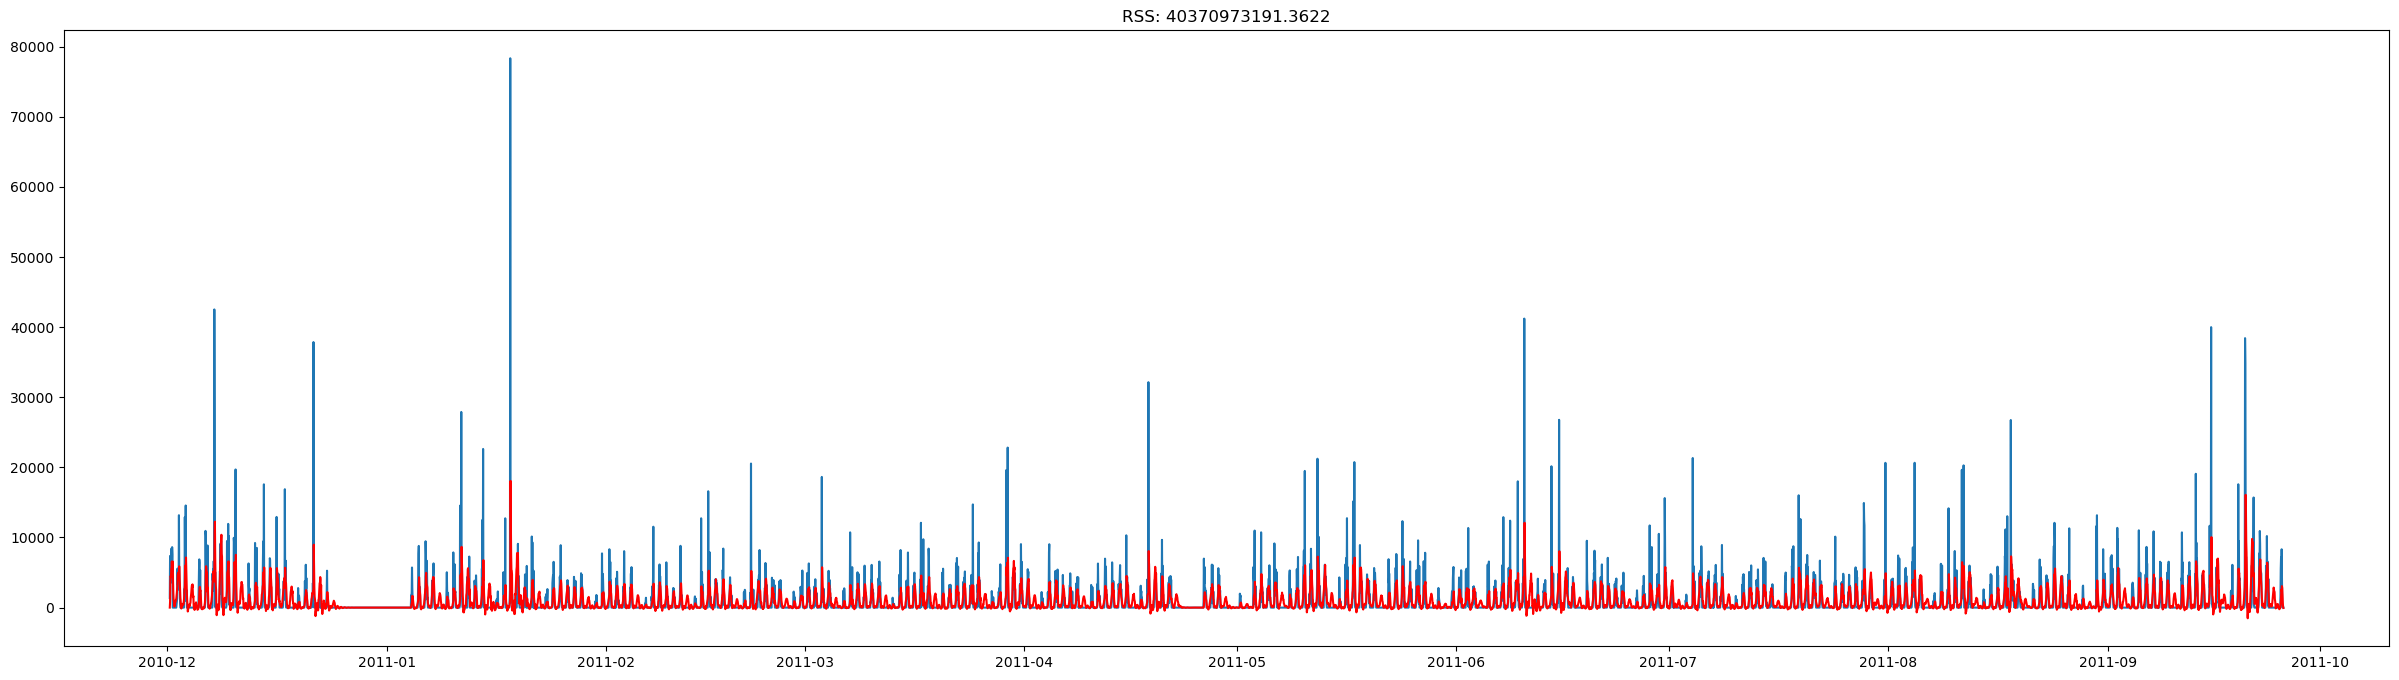

In [26]:
plt.subplots(figsize=(30,8))
plt.plot(train)
plt.plot(results_model.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_model.fittedvalues - train['sales'])**2))
print('Plotting AR model')

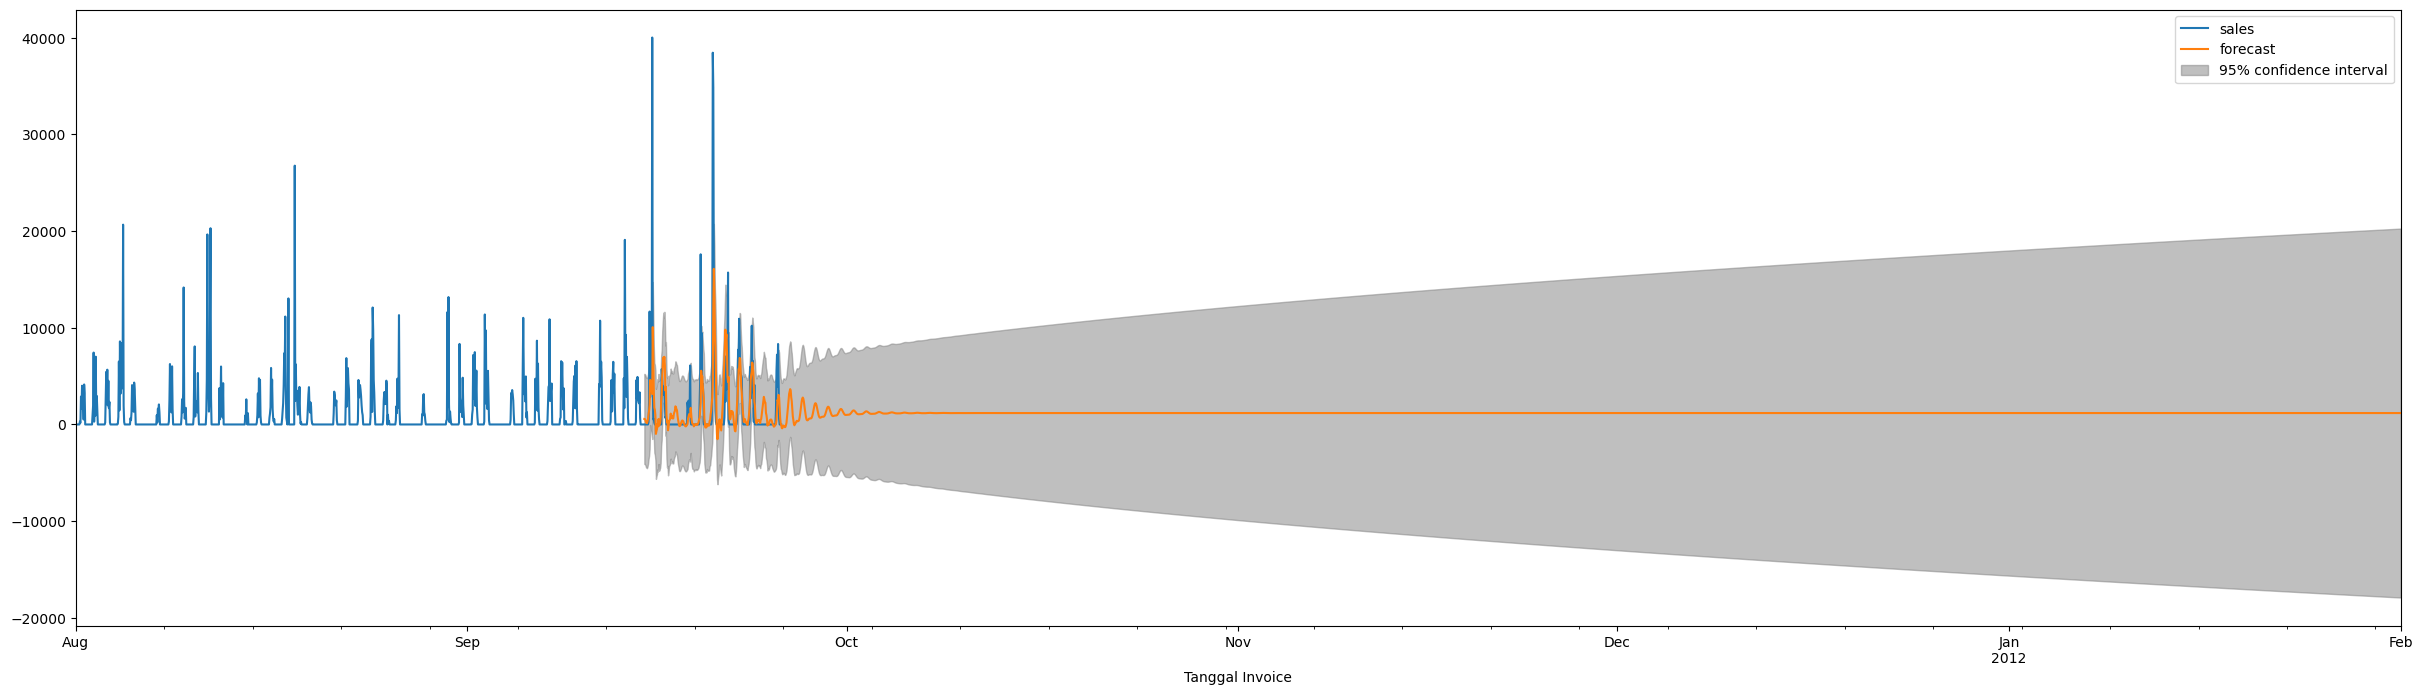

In [27]:
from statsmodels.graphics.tsaplots import plot_predict
fig, ax = plt.subplots(figsize=(30,8))
ax = train.loc['2011-08':].plot(ax=ax)
plot_predict(results_model, '2011-09-15', '2012-02', ax=ax)
plt.show()

In [28]:
excel = pd.ExcelWriter('outputfixed.xlsx')

# write each dataframe to a different sheet
daily_df.to_excel(excel, sheet_name='daily')
weekly_df.to_excel(excel, sheet_name='weekly')
monthly_df.to_excel(excel, sheet_name='monthly')

excel.save()

<p id="part2"></p>
<h2>XGBOOST Model</h2>

In [29]:
hourly_df

,sales
Tanggal Invoice,
2010-12-01 08:00:00,1383.81
2010-12-01 09:00:00,7356.39
2010-12-01 10:00:00,5235.81
2010-12-01 11:00:00,4234.16
2010-12-01 12:00:00,7447.92
...,...
2011-12-09 08:00:00,3581.93
2011-12-09 09:00:00,171679.08
2011-12-09 10:00:00,19663.42


In [30]:
def add_features(df, num_lag):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    for i in range(1, num_lag):
        df[f"lags{i}"] = df[df.columns[0]].shift(i)
        
    return df

In [31]:
def handling_missingval(df):
    imputer = IterativeImputer(random_state=42)
    imputed = imputer.fit_transform(df)
    df = pd.DataFrame(imputed, columns=df.columns, index=df.index)
    return df

In [32]:
df_feature = add_features(hourly_df, 30)
df_fix = handling_missingval(df_feature)
df_fix.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags20,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29
Tanggal Invoice,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:00:00,1383.81,8.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1260.409077,...,1209.482343,1216.876412,1223.880222,1230.163195,1231.986951,1222.550672,1215.295366,1206.214817,1195.864574,1190.041770
2010-12-01 09:00:00,7356.39,9.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1383.810000,...,1718.234393,2004.793337,2242.551303,2455.659617,2496.153494,2155.654829,2002.329438,1731.023226,1481.532843,1329.827731
2010-12-01 10:00:00,5235.81,10.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,7356.390000,...,1734.454251,2031.196813,2399.872083,2703.109243,2913.024275,2796.368165,2382.783804,2137.803560,1774.645919,1486.869033
2010-12-01 11:00:00,4234.16,11.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,5235.810000,...,1517.310796,1890.006380,2221.619089,2618.536807,2916.397954,3048.512187,2892.254072,2430.899750,2147.681873,1761.534265
2010-12-01 12:00:00,7447.92,12.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,4234.160000,...,1788.943877,2185.838113,2678.528444,3100.752605,3462.748394,3432.516219,3374.868823,2984.403168,2378.554627,1973.322576


In [33]:

df_fix.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags20,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29
Tanggal Invoice,,,,,,,,,,,,,,,,,,,,,
2010-12-01 08:00:00,1383.81,8.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1260.409077,...,1209.482343,1216.876412,1223.880222,1230.163195,1231.986951,1222.550672,1215.295366,1206.214817,1195.864574,1190.041770
2010-12-01 09:00:00,7356.39,9.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1383.810000,...,1718.234393,2004.793337,2242.551303,2455.659617,2496.153494,2155.654829,2002.329438,1731.023226,1481.532843,1329.827731
2010-12-01 10:00:00,5235.81,10.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,7356.390000,...,1734.454251,2031.196813,2399.872083,2703.109243,2913.024275,2796.368165,2382.783804,2137.803560,1774.645919,1486.869033
2010-12-01 11:00:00,4234.16,11.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,5235.810000,...,1517.310796,1890.006380,2221.619089,2618.536807,2916.397954,3048.512187,2892.254072,2430.899750,2147.681873,1761.534265
2010-12-01 12:00:00,7447.92,12.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,4234.160000,...,1788.943877,2185.838113,2678.528444,3100.752605,3462.748394,3432.516219,3374.868823,2984.403168,2378.554627,1973.322576


In [34]:
per80 = int(len(df_fix)*0.8)
train_xgb = df_fix[:per80]
val_xgb = df_fix[per80:]
train_xgb.tail()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags20,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29
Tanggal Invoice,,,,,,,,,,,,,,,,,,,,,
2011-09-25 16:00:00,601.54,16.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,4314.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 17:00:00,0.00,17.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,601.54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 18:00:00,0.00,18.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 19:00:00,0.00,19.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 20:00:00,0.00,20.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


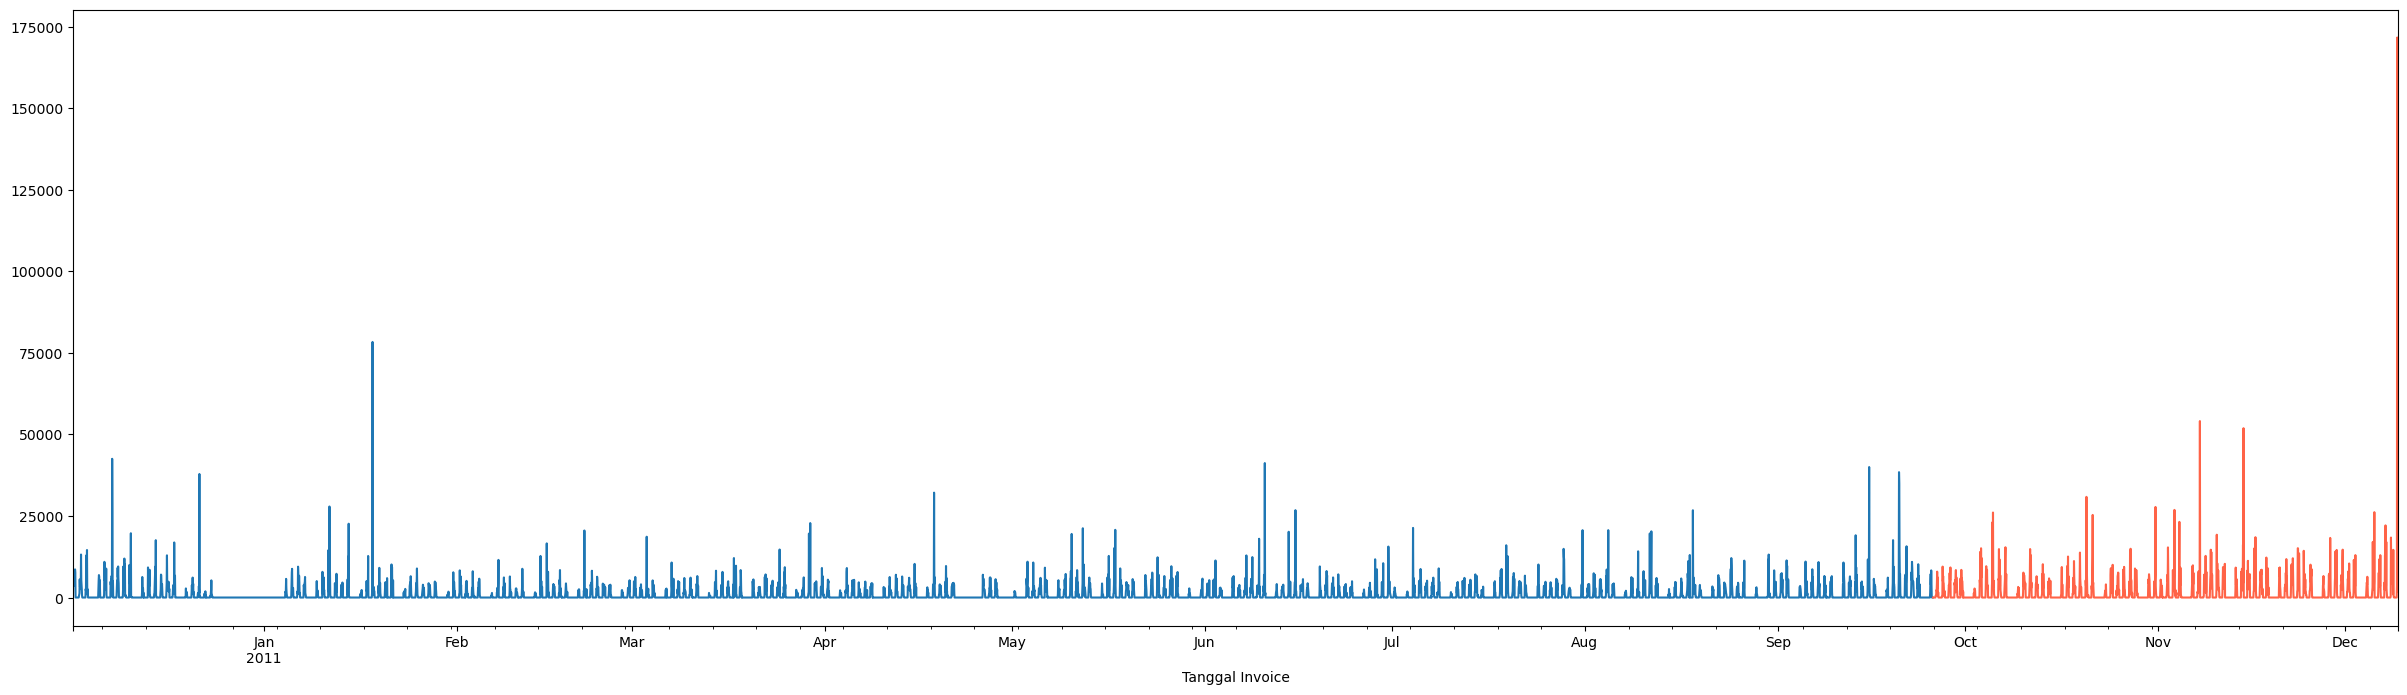

In [35]:
plt.figure(figsize=(30,8))
train_xgb['sales'].plot()
val_xgb['sales'].plot(color='tomato')
plt.show()

In [36]:
val_xgb.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags20,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29
Tanggal Invoice,,,,,,,,,,,,,,,,,,,,,
2011-09-25 21:00:00,0.0,21.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 22:00:00,0.0,22.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-25 23:00:00,0.0,23.0,6.0,3.0,9.0,2011.0,268.0,25.0,38.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-26 00:00:00,0.0,0.0,0.0,3.0,9.0,2011.0,269.0,26.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-09-26 01:00:00,0.0,1.0,0.0,3.0,9.0,2011.0,269.0,26.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h4>Make a dummy data to predict the future</h4>

In [37]:
start_date = val_xgb.index.max() + pd.Timedelta(hours=1)
end_date = start_date + pd.Timedelta(days=30)

future_time = pd.date_range(start_date, end_date, freq='1H')
future_df = pd.DataFrame(index=future_time)
future_df['isFuture'] = True
df_fix['isFuture'] = False

df_and_future = pd.concat([df_fix, future_df])

df_and_future_with_feature = add_features(df_and_future, 30)
df_and_future_with_feature = handling_missingval(df_and_future_with_feature[df_and_future_with_feature.columns[1:]])

df_and_future_fix = pd.merge(df_and_future[df_and_future.columns[0]], df_and_future_with_feature, left_index=True, right_index=True)
df_and_future_fix.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29,isFuture
2010-12-01 08:00:00,1383.81,8.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1219.007517,...,1203.013918,1204.038164,1205.051672,1205.916953,1206.374712,1205.989226,1205.997084,1206.359234,1206.623328,0.0
2010-12-01 09:00:00,7356.39,9.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,1383.810000,...,1219.617675,1230.932301,1241.882845,1252.662143,1257.259247,1246.604192,1239.435120,1229.712119,1219.753991,0.0
2010-12-01 10:00:00,5235.81,10.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,7356.390000,...,1776.185456,2109.772301,2392.925276,2678.146437,2725.089904,2249.204974,2081.490305,1755.673182,1460.004457,0.0
2010-12-01 11:00:00,4234.16,11.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,5235.810000,...,1802.285761,2112.448823,2541.616955,2915.271352,3197.863026,3032.488866,2472.509739,2195.258202,1767.643431,0.0
2010-12-01 12:00:00,7447.92,12.0,2.0,4.0,12.0,2010.0,335.0,1.0,48.0,4234.160000,...,1549.470810,1956.051697,2307.368261,2779.271854,3149.041284,3328.811051,3120.084544,2506.373507,2184.404262,0.0


In [38]:
future_xgb = df_and_future_fix.query('isFuture == 1').copy()
future_xgb = future_xgb.drop('isFuture', axis=1)
future_xgb.head()

,sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lags1,...,lags20,lags21,lags22,lags23,lags24,lags25,lags26,lags27,lags28,lags29
2011-12-09 13:00:00,NaN,13.0,4.0,4.0,12.0,2011.0,343.0,9.0,49.0,4132.480000,...,984.16,8398.95,4928.90,4257.03,4873.71,8061.16,8629.80,7791.16,18384.35,482.28
2011-12-09 14:00:00,NaN,14.0,4.0,4.0,12.0,2011.0,343.0,9.0,49.0,9594.947451,...,14620.64,984.16,8398.95,4928.90,4257.03,4873.71,8061.16,8629.80,7791.16,18384.35
2011-12-09 15:00:00,NaN,15.0,4.0,4.0,12.0,2011.0,343.0,9.0,49.0,10297.232700,...,1021.31,14620.64,984.16,8398.95,4928.90,4257.03,4873.71,8061.16,8629.80,7791.16
2011-12-09 16:00:00,NaN,16.0,4.0,4.0,12.0,2011.0,343.0,9.0,49.0,6772.627864,...,61.55,1021.31,14620.64,984.16,8398.95,4928.90,4257.03,4873.71,8061.16,8629.80
2011-12-09 17:00:00,NaN,17.0,4.0,4.0,12.0,2011.0,343.0,9.0,49.0,-1059.864695,...,0.00,61.55,1021.31,14620.64,984.16,8398.95,4928.90,4257.03,4873.71,8061.16


In [39]:
FEATURES = train_xgb.columns[1:]
TARGET = train_xgb.columns[0]

In [40]:
train_xgb.head(), val_xgb.head(), future_xgb.head()

(                       sales  hour  dayofweek  quarter  month    year  \
 Tanggal Invoice                                                         
 2010-12-01 08:00:00  1383.81   8.0        2.0      4.0   12.0  2010.0   
 2010-12-01 09:00:00  7356.39   9.0        2.0      4.0   12.0  2010.0   
 2010-12-01 10:00:00  5235.81  10.0        2.0      4.0   12.0  2010.0   
 2010-12-01 11:00:00  4234.16  11.0        2.0      4.0   12.0  2010.0   
 2010-12-01 12:00:00  7447.92  12.0        2.0      4.0   12.0  2010.0   
 
                      dayofyear  dayofmonth  weekofyear        lags1  ...  \
 Tanggal Invoice                                                      ...   
 2010-12-01 08:00:00      335.0         1.0        48.0  1260.409077  ...   
 2010-12-01 09:00:00      335.0         1.0        48.0  1383.810000  ...   
 2010-12-01 10:00:00      335.0         1.0        48.0  7356.390000  ...   
 2010-12-01 11:00:00      335.0         1.0        48.0  5235.810000  ...   
 2010-12-01 12:00:

In [41]:
model_dir = '/kaggle/input/model-xgb1'
model_filename = 'model_xgb.model'

if os.path.exists(os.path.join(model_dir, model_filename)):
    # Load the saved model from file
    model_xgb = xgb.XGBRegressor()
    model_xgb.load_model('/kaggle/input/model-xgb1/model_xgb.model')
    print("ada cuy mantap")
else:
    model_xgb = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=100000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
    model_xgb.fit(train_xgb[FEATURES], train_xgb[TARGET],
            eval_set=[(train_xgb[FEATURES], train_xgb[TARGET])],
            verbose=10000)
    model_xgb.save_model("model_xgb.model")

[06:11:03] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
ada cuy mantap


In [42]:
val_xgb['pred'] = model_xgb.predict(val_xgb[FEATURES])

<AxesSubplot:xlabel='Tanggal Invoice'>

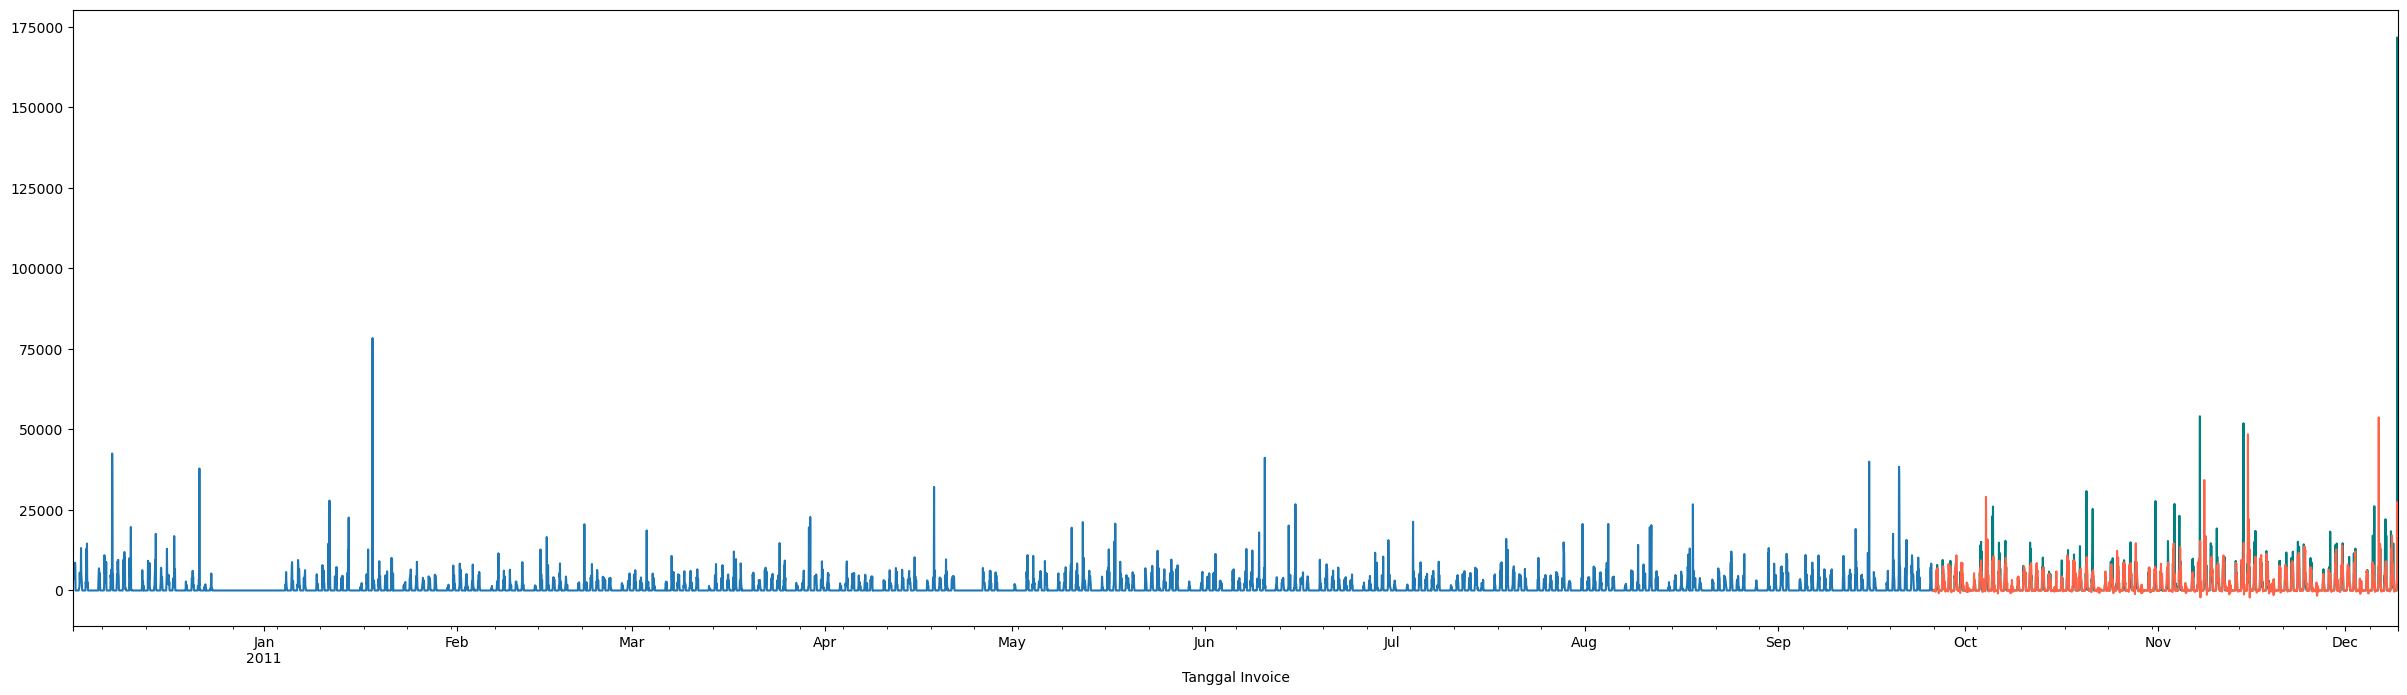

In [43]:
plt.figure(figsize=(30,8))
train_xgb['sales'].plot()
val_xgb['sales'].plot(color='teal')
val_xgb['pred'].plot(color='tomato')

<AxesSubplot:>

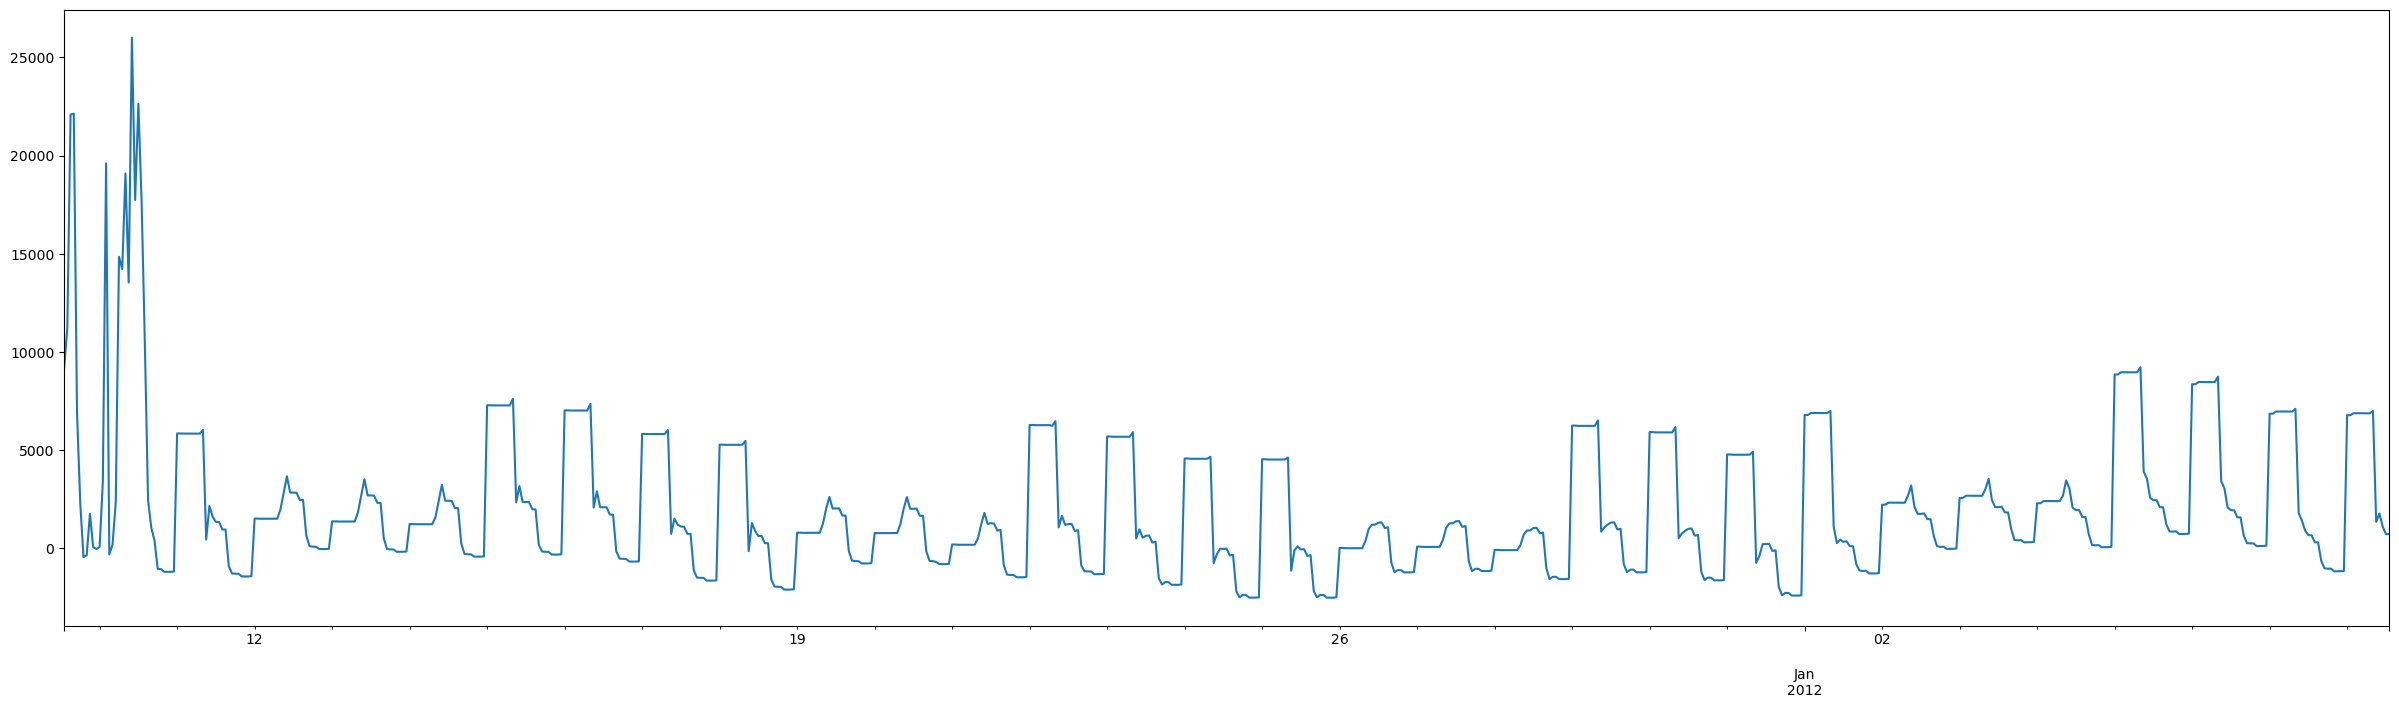

In [44]:
future_xgb['sales']=model_xgb.predict(future_xgb[FEATURES])
plt.figure(figsize=(30,8))
future_xgb['sales'].plot()

<p id="part3"></p>
<h2>GRU Model</h2>

<p>And for the last attempts, I try to forecast the data using the descendant of RNN, which is GRU</p>

In [45]:
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras.optimizers import SGD
from tensorflow.keras.models import load_model

In [46]:
tf.random.set_seed(1234)

In [47]:
hourly_df.head()

,sales
Tanggal Invoice,
2010-12-01 08:00:00,1383.81
2010-12-01 09:00:00,7356.39
2010-12-01 10:00:00,5235.81
2010-12-01 11:00:00,4234.16
2010-12-01 12:00:00,7447.92


In [48]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(hourly_df)
scaled_df

array([[0.00806045],
       [0.04284966],
       [0.03049766],
       ...,
       [0.11453591],
       [0.01085566],
       [0.02407096]])

In [49]:
per80_gru = int(len(hourly_df)*0.8)
train_gru = scaled_df[:per80_gru]
val_gru = scaled_df[per80_gru:]
train_gru

array([[0.00806045],
       [0.04284966],
       [0.03049766],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [50]:
def create_input(df, total_lookback=1):
    X = []
    y = []
    
    for i in range (len(df) - total_lookback):
        window = df[i:i+total_lookback]
        X.append(window)
        y.append(df[i+total_lookback])
        
    return np.array(X), np.array(y)

In [51]:
total_window = 24*15
X_train, y_train = create_input(train_gru, total_window)
X_val, y_val = create_input(val_gru, total_window)
X_total, y_total = create_input(scaled_df, total_window)

In [52]:
model_dir = '/kaggle/input/my-gru-model'
model_filename = 'GRU_1.h5'

if os.path.exists(os.path.join(model_dir, model_filename)):
    # If the file exists, load the saved model
    regressorGRU = load_model(os.path.join(model_dir, model_filename))
    print("ada cuy mantap")
else:
    # If the file doesn't exist, create a new model and train it
    # Define the model architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))

    # The output layer
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

    # Fitting to the training set
    regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

ada cuy mantap


In [53]:
prediction = regressorGRU.predict(X_val)
prediction = scaler.inverse_transform(prediction)

45/45 [==============================] - 8s 146ms/step


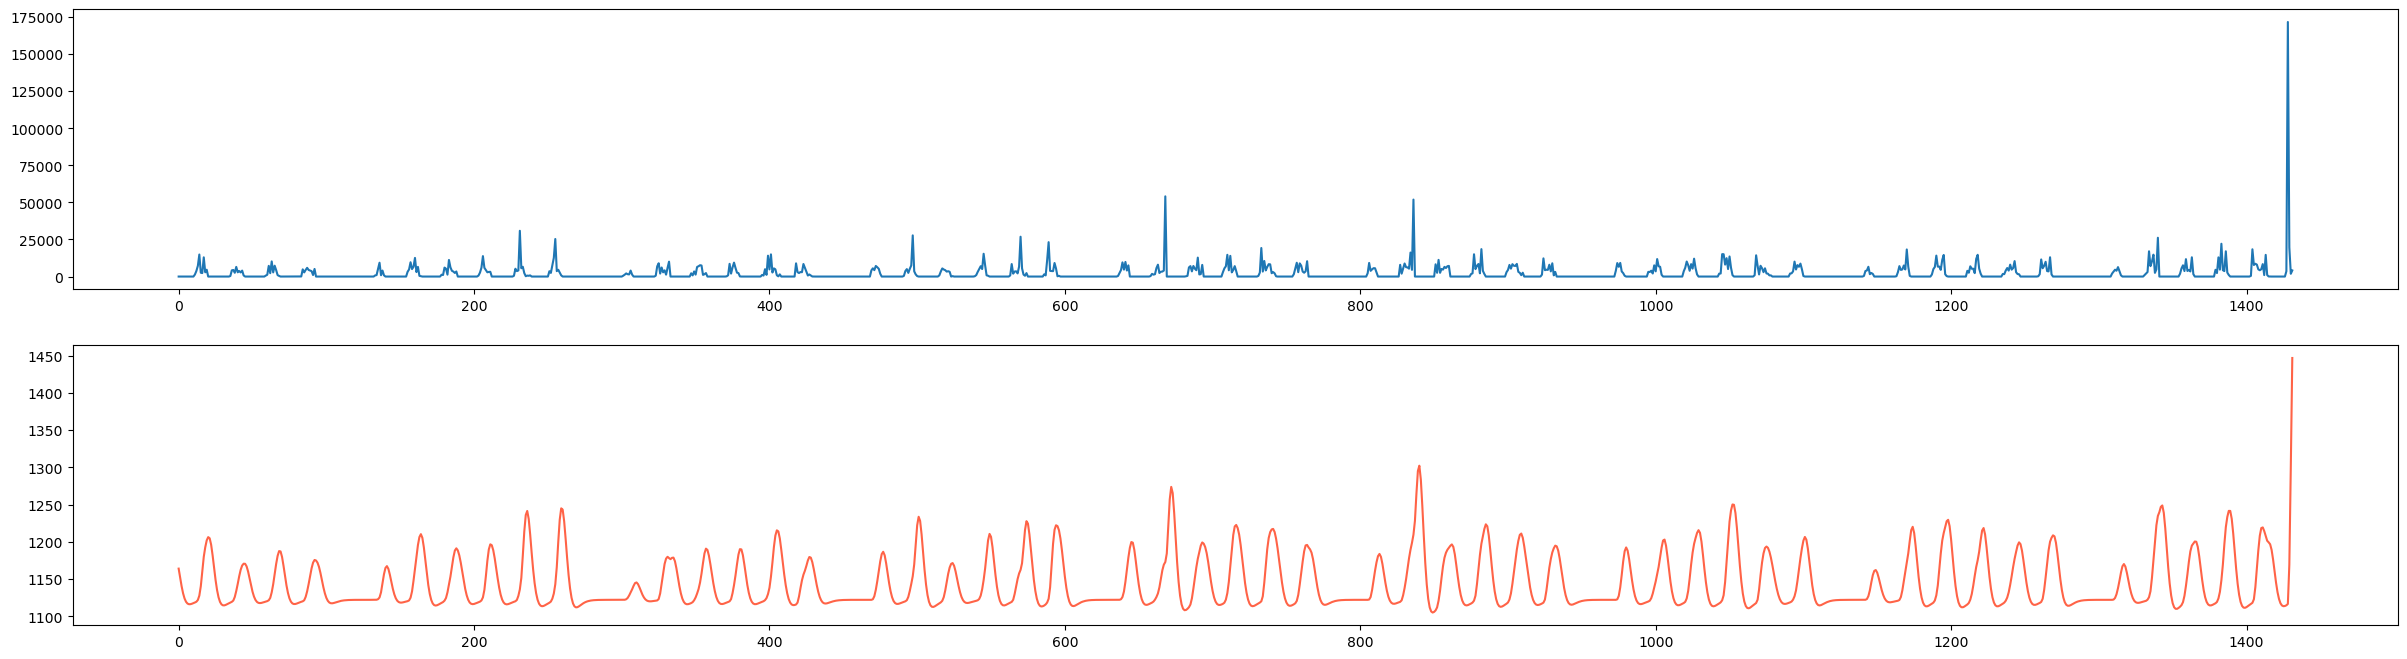

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(30,8))
range_future = len(prediction)
unscaled_y_val = scaler.inverse_transform(y_val)


ax[0].plot(unscaled_y_val)
ax[1].plot(prediction, color='tomato')

In [55]:
#retrain with the whole data
regressorGRU.fit(X_total, y_total, epochs=16, batch_size=64)

Epoch 1/16
135/135 [==============================] - 112s 789ms/step - loss: 4.2166e-04
Epoch 2/16
135/135 [==============================] - 107s 795ms/step - loss: 4.2070e-04
Epoch 3/16
135/135 [==============================] - 108s 799ms/step - loss: 4.1931e-04
Epoch 4/16
135/135 [==============================] - 107s 789ms/step - loss: 4.2343e-04
Epoch 5/16
135/135 [==============================] - 107s 790ms/step - loss: 4.1938e-04
Epoch 6/16
135/135 [==============================] - 108s 799ms/step - loss: 4.1970e-04
Epoch 7/16
135/135 [==============================] - 107s 792ms/step - loss: 4.1946e-04
Epoch 8/16
135/135 [==============================] - 107s 791ms/step - loss: 4.2134e-04
Epoch 9/16
135/135 [==============================] - 107s 792ms/step - loss: 4.2068e-04
Epoch 10/16
135/135 [==============================] - 108s 797ms/step - loss: 4.2112e-04
Epoch 11/16
135/135 [==============================] - 108s 797ms/step - loss: 4.1932e-04
Epoch 12/16
135/135

<h3>Make algorithm to do prediction using GRU</h3>

In [56]:
aa = X_val[-1:];
aa_ = X_val[-1]
bb = regressorGRU.predict(aa)
cc = np.concatenate((aa_, bb.reshape(1,1)), axis=0)[1:]
ee = np.array(cc).reshape(1, 360, 1)
#ee = ee[:, np.newaxis, :]
isinstance(ee, np.ndarray)
dd = regressorGRU.predict(ee)
dd
#aa.shape

1/1 [==============================] - 0s 100ms/step


array([[0.01037156]], dtype=float32)

In [57]:
def GRU_predict(model, total_step):
    
    #first we need to predict thelast value from the  
    dummy_train = X_val[-1:]
    dummy_add = X_val[-1]
    dummy_y = model.predict(dummy_train)
    dummy_X = np.concatenate((dummy_add, dummy_y.reshape(1,1)), axis=0)[1:]
    
    #prediction 
    prediction = np.empty(total_step)
    for i in range(1, total_step):
        dummy_X = np.array(dummy_X).reshape(1, 360, 1)
        dummy_y = model.predict(dummy_X);
        dummy_X= np.concatenate((dummy_X.reshape(360,1), dummy_y.reshape(1,1)), axis=0)[1:]
        prediction[i] = dummy_y
    return dummy_X, prediction

1/1 [==============================] - 0s 84ms/step


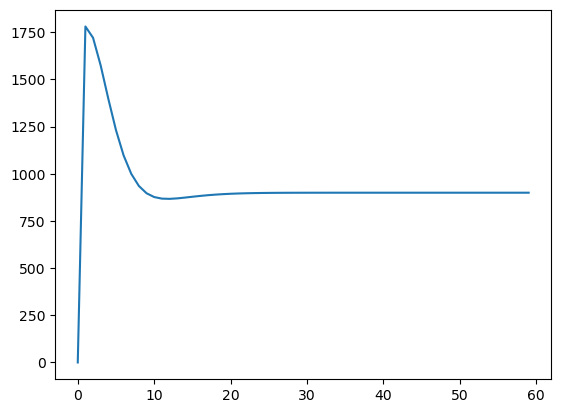

In [58]:
steps = 60
last_X, future = GRU_predict(regressorGRU, steps);
future = future.reshape(steps, 1)
future = scaler.inverse_transform(future)
plt.plot(future)

<p>and here we can predict the future with the algorithm that commonly used in an online-learning model</p>